In [1]:
from fitparse import FitFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import time
import glob
import requests
from json import JSONDecodeError
import folium
import math

From the cell below we can learn a few things:
1. The number of stations has grown every year (we might be able to use this for a diff-in-diff)
2. All riders datasets have the columns ['start_date', 'start_station_code', 'end_date', 'end_station_code','duration_sec', 'is_member']


In [2]:
## Look at the number of stations each year
year = 2014
for file in glob.iglob(r'C:\Users\liama\OneDrive\data_projects\bicycle-share-montreal\Montreal*\Stations*.csv'):
    df = pd.read_csv(file)
    print(year , len(df.index))
    year += 1

    
## Look at what columns exist in each file, they are all the same so print out just one
df = pd.read_csv(r'C:\Users\liama\OneDrive\data_projects\bicycle-share-montreal\Montreal2019\OD_2019-04.csv')
print(df.columns)


2014 459
2015 460
2016 465
2017 546
2018 552
2019 619
Index(['start_date', 'start_station_code', 'end_date', 'end_station_code',
       'duration_sec', 'is_member'],
      dtype='object')


# MAPS
Want to make a few maps the maps I am attempting to make in the code blocks are as follows:
1. Just show the stations
2. Show the stations by elevation
3. Show the stations by rides began and ended
4. If possible combine the last 2

In [9]:
## First we will generate a dataframe that aggregates the trips by station and contains altitude and longitude
df = pd.read_csv('rides_by_station.csv',dtype = {'station_code': int , 
                                                 'date' : 'str' , 
                                                 'trips_began':int,
                                                  'trips_ended':float , 
                                                 'lat': float ,
                                                 'long' : float ,
                                                 'altitude': float},parse_dates = True)

## This has to be temporary there is some nan values in trips_ended but this changes the results in weird ways
df = df.dropna()
maps = df.groupby(['station_code','lat','long','altitude'],as_index = False)['trips_began','trips_ended'].apply(lambda x : x.astype(int).mean()).reset_index()

df.head()

,station_code,date,trips_began,trips_ended,lat,long,altitude
0,10002,2014-04-25,10,16.0,45.478228,-73.569651,16.0
1,10002,2014-04-26,4,4.0,45.478228,-73.569651,16.0
2,10002,2014-04-27,10,14.0,45.478228,-73.569651,16.0
3,10002,2014-04-28,26,19.0,45.478228,-73.569651,16.0
4,10002,2014-04-29,29,33.0,45.478228,-73.569651,16.0


In [4]:

montreal = folium.Map(location=[maps.loc[0,'lat'], maps.loc[0,'long']], zoom_start=12)
for i in maps.index:
    folium.Marker( [maps.iloc[i]['lat'],maps.iloc[i]['long']], popup=maps.iloc[i]['station_code']).add_to(montreal)
montreal


# GRAPHING TRIPS BY ELEVATION
What we can see from the plot below is that the highest number of trips (ended and began) seem to be at a few stations in the middle of the elevation range.  However, among the observations there are more stations with over 100 average day trips ended then began at the lower elevation levels.  Also among the stations above 80 meters elevation gain we can see that the trips began are slightly higher than trips ended.

No handles with labels found to put in legend.


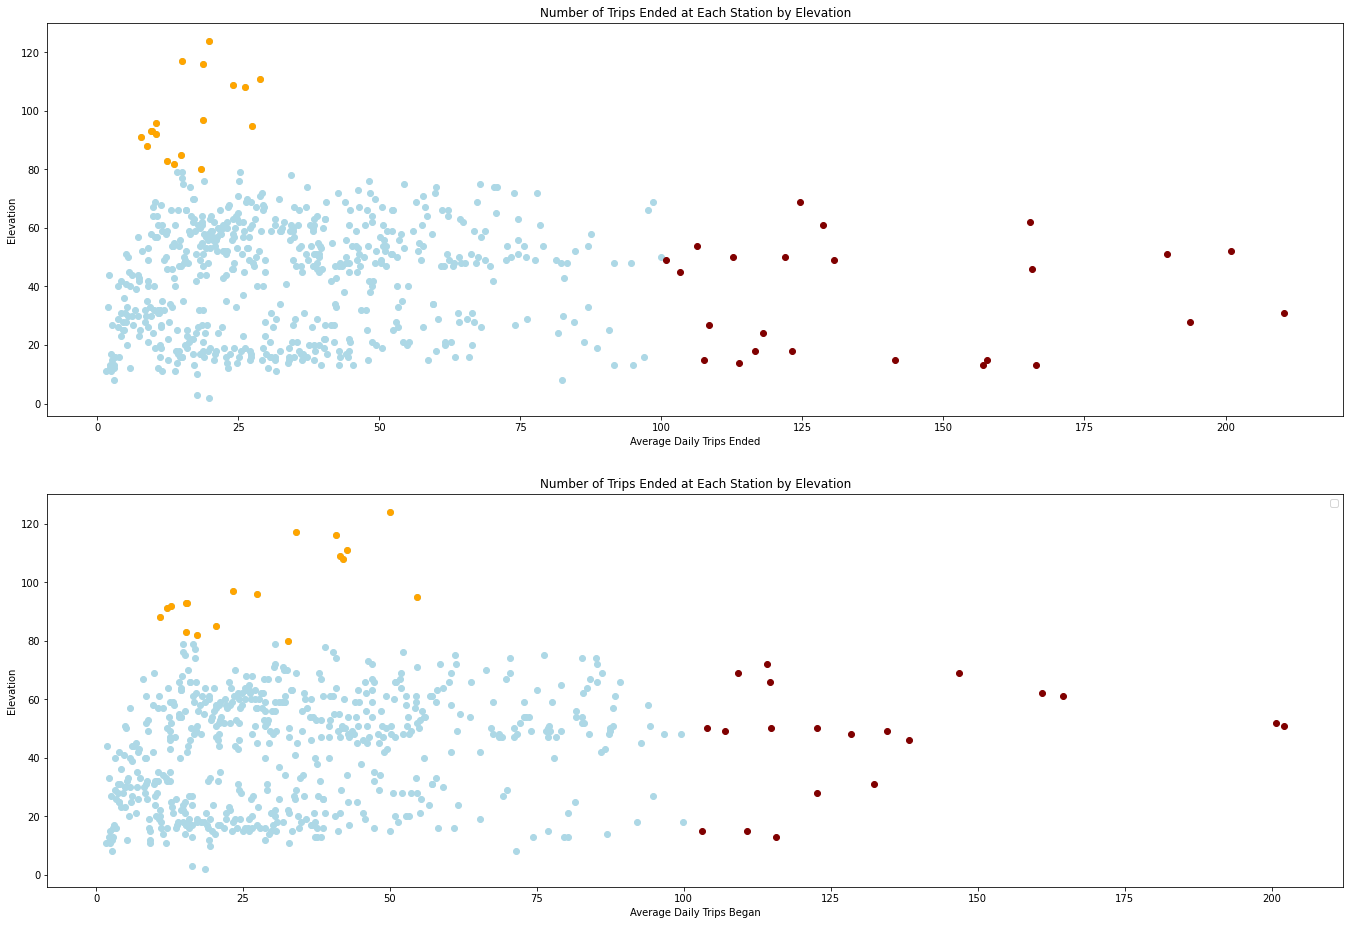

In [5]:
fig = plt.figure()
ax1 =  fig.add_subplot(211)
ax2 =  fig.add_subplot(212)
ax1.scatter(maps['trips_ended'][maps['trips_ended'] < 100],maps['altitude'][maps['trips_ended'] < 100],color = 'lightblue')
ax1.scatter(maps['trips_ended'][maps['trips_ended'] >= 100], maps['altitude'][maps['trips_ended'] >= 100], color = 'maroon')
ax1.scatter(maps['trips_ended'][maps['altitude'] >= 80], maps['altitude'][maps['altitude'] >= 80], color = 'orange')
ax1.set_xlabel('Average Daily Trips Ended')
ax1.set_ylabel('Elevation')
ax1.set_title('Number of Trips Ended at Each Station by Elevation')
ax1.set_xticks([0,25,50,75,100,125,150,175,200])

ax2.scatter(maps['trips_began'][maps['trips_began'] < 100],maps['altitude'][maps['trips_began'] < 100],color = 'lightblue')
ax2.scatter(maps['trips_began'][maps['trips_began'] >= 100], maps['altitude'][maps['trips_began'] >= 100], color = 'maroon')
ax2.scatter(maps['trips_began'][maps['altitude'] >= 80], maps['altitude'][maps['altitude'] >= 80], color = 'orange')
ax2.set_xlabel('Average Daily Trips Began')
ax2.set_ylabel('Elevation')
ax2.set_title('Number of Trips Ended at Each Station by Elevation')
ax2.legend()
plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0, hspace=0.2)
handles, labels = ax1.get_legend_handles_labels()

plt.show()

In [6]:
## Define a function that calaculates the distance to the central station using 
def distance_to_central(lat,long):
    #Radius of the earth
    R = 6373.0
    #Radians of central station coordinates
    c_lat = math.radians(45.5001)
    c_long = math.radians(-73.5665)
    
    dlat = c_lat - math.radians(lat)
    dlong = c_long - math.radians(long)
    
    a = math.sin(dlat / 2)**2 + math.cos(lat) * math.cos(c_lat) * math.sin(dlong / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance
maps['distance'] = 0
for i in maps.index:
    maps.loc[i,'distance'] = distance_to_central(maps.loc[i,'lat'] , maps.loc[i,'long'])


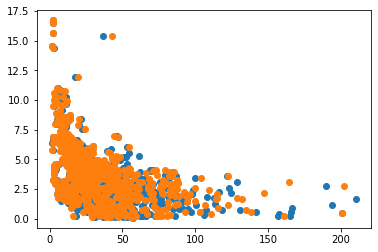

In [7]:
plt.scatter(maps['trips_ended'],maps['distance'])
plt.scatter(maps['trips_began'],maps['distance'])